<a href="https://colab.research.google.com/github/Chidu2000/AI_chatbot_using_Flask/blob/main/Dog_Breed_Prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
# run this cell to connect to kaggle API via .json file
from google.colab import files
files.upload()

Saving kaggle.json to kaggle (1).json


{'kaggle.json': b'{"username":"chidambarjoshi","key":"baccbcefbe54dd3f3ce32117fcba6634"}'}

In [3]:
# Install Kaggle API client
!pip install -q kaggle 

In [4]:
# kaggle API expects this to be in ~/.kaggle 
!mkdir -p ~/.kaggle 
!cp kaggle.json ~/.kaggle 

!chmod 600 ~/.kaggle/kaggle.json

In [5]:
# creating directory and changing pwd
!mkdir dog_dataset
%cd dog_dataset

mkdir: cannot create directory ‘dog_dataset’: File exists
/content/dog_dataset


In [6]:
# searching dataset
!kaggle datasets list -s dogbreedidfromcomp

ref                                title                    size  lastUpdated          downloadCount  voteCount  usabilityRating  
---------------------------------  ----------------------  -----  -------------------  -------------  ---------  ---------------  
catherinehorng/dogbreedidfromcomp  dog-breed-id-from-comp  691MB  2020-06-26 03:09:05           1466          6  0.1764706        


In [20]:
#dowloading dataset
!kaggle datasets download catherinehorng/dogbreedidfromcomp
%cd ..

 99% 687M/691M [00:04<00:00, 148MB/s]
100% 691M/691M [00:04<00:00, 159MB/s]
/content


In [22]:
#unzip and remove unusable files
!unzip dog_dataset/dogbreedidfromcomp.zip -d dog_dataset
!rm dog_dataset/dogbreedidfromcomp.zip
!rm dog_dataset/sample_submission.csv

unzip:  cannot find or open dog_dataset/dogbreedidfromcomp.zip, dog_dataset/dogbreedidfromcomp.zip.zip or dog_dataset/dogbreedidfromcomp.zip.ZIP.
rm: cannot remove 'dog_dataset/dogbreedidfromcomp.zip': No such file or directory
rm: cannot remove 'dog_dataset/sample_submission.csv': No such file or directory


In [8]:
#importing required libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from tqdm import tqdm   # used for creating progress meters/bars
from keras.preprocessing import image
from sklearn.preprocessing import label_binarize
from sklearn.model_selection import train_test_split
from keras.models import Sequential
from keras.layers import Dense,Dropout,Flatten, Conv2D , MaxPool2D
from tensorflow.keras.optimizers import Adam

In [9]:
# Read labels.csv file and checking shape and records

labels_all = pd.read_csv('/content/dog_dataset/labels.csv')
print(labels_all.shape)
labels_all.head()

(10222, 2)


,id,breed
0,000bec180eb18c7604dcecc8fe0dba07,boston_bull
1,001513dfcb2ffafc82cccf4d8bbaba97,dingo
2,001cdf01b096e06d78e9e5112d419397,pekinese
3,00214f311d5d2247d5dfe4fe24b2303d,bluetick
4,0021f9ceb3235effd7fcde7f7538ed62,golden_retriever


In [10]:
# visualize number of each breeds
breeds_all  = labels_all['breed']
breed_counts = breeds_all.value_counts()
breed_counts.head()

scottish_deerhound      126
maltese_dog             117
afghan_hound            116
entlebucher             115
bernese_mountain_dog    114
Name: breed, dtype: int64

In [11]:
# selecting first 3 breeds(computational limitations)
CLASS_NAMES = ['scottish_deerhound','maltese_dog','afghan_hound']
labels = labels_all[(labels_all['breed'].isin(CLASS_NAMES))].reset_index()
labels.head()

,index,id,breed
0,9,0042188c895a2f14ef64a918ed9c7b64,scottish_deerhound
1,12,00693b8bc2470375cc744a6391d397ec,maltese_dog
2,79,01e787576c003930f96c966f9c3e1d44,scottish_deerhound
3,90,022b34fd8734b39995a9f38a4f3e7b6b,maltese_dog
4,146,0379145880ad3978f9b80f0dc2c03fba,afghan_hound


In [23]:
# Creating numpy matrix with zeros
X_data = np.zeros((len(labels),224,224,3),dtype='float32')

#One hot encoding
Y_data = label_binarize(labels['breed'],classes=CLASS_NAMES)

#reading and converting images to numpy array and normalizing dataset
for i in tqdm(range(len(labels))):
  img = image.load_img('dog_dataset/train/%s.jpg' % labels['id'][i],target_size=(224,224))
  img = image.img_to_array(img)
  x = np.expand_dims(img.copy(),axis=0)
  X_data[i] = x/255.0


# printing train image and one hot encode shape and size
print('\n Train Images Shape:',X_data.shape,'size: {:,}'.format(X_data.size))
print('One-hot encoded output shape:',Y_data.shape,'size: {:,}'.format(Y_data.size))

 #NOTE:  shape -> 359 images , 224*224 is the size and 3 is channels(RGB) colored images

100%|██████████| 359/359 [00:02<00:00, 124.19it/s]


 Train Images Shape: (359, 224, 224, 3) size: 54,039,552
One-hot encoded output shape: (359, 3) size: 1,077


In [13]:
# Building the model
# Note: hyperparameter tuning-> Changing the no. of filters and parameters to obtain higher accuracy output
# conv2D is used to create convolutional kernel with i/p layer to produce o/p tensor
# Dense layer produces the o/p as the cross product of input and kernel

model = Sequential()

model.add(Conv2D(filters=64,kernel_size=(5,5),activation='relu',input_shape=(224,224,3)))
model.add(MaxPool2D(pool_size=(2,2)))  # findouts max dominant feature in a 2*2 matrix(window defined by poolsize)

model.add(Conv2D(filters=32,kernel_size=(3,3),activation='relu',kernel_regularizer='l2'))
model.add(MaxPool2D(pool_size=(2,2)))  

model.add(Conv2D(filters=16,kernel_size=(7,7),activation='relu',kernel_regularizer='l2'))
model.add(MaxPool2D(pool_size=(2,2)))  

model.add(Conv2D(filters=8,kernel_size=(5,5),activation='relu',kernel_regularizer='l2'))
model.add(MaxPool2D(pool_size=(2,2)))  

model.add(Flatten())  #flattens input and creates 1D output
model.add(Dense(128,activation='relu',kernel_regularizer='l2'))
model.add(Dense(64,activation='relu',kernel_regularizer='l2'))

#in a multiclass classification, generally activation func will be softmax
model.add(Dense(len(CLASS_NAMES),activation='softmax'))

model.compile(loss='categorical_crossentropy',optimizer=Adam(0.0001),metrics=['accuracy'])

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 220, 220, 64)      4864      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 110, 110, 64)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 108, 108, 32)      18464     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 54, 54, 32)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 48, 48, 16)        25104     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 24, 24, 16)       0

In [14]:
# splitting the data set into training and testing 
X_train_and_val, X_test, Y_train_and_val, Y_test = train_test_split(X_data,Y_data,test_size=0.1)

#splitting training dataset into training and validation datasets
X_train,X_val,Y_train,Y_val = train_test_split(X_train_and_val,Y_train_and_val,test_size=0.2)

In [24]:
#training and model
epochs = 70
batch_size = 128

history = model.fit(X_train, Y_train, batch_size = batch_size, epochs=epochs, validation_data=(X_val,Y_val))

# during the epochs we can see how the model is performing by viewing the training and validation accuracy

Epoch 1/70
3/3 [==============================] - 33s 9s/step - loss: 4.6001 - accuracy: 0.3566 - val_loss: 4.5706 - val_accuracy: 0.3385
Epoch 2/70
3/3 [==============================] - 31s 8s/step - loss: 4.5645 - accuracy: 0.3566 - val_loss: 4.5353 - val_accuracy: 0.3385
Epoch 3/70
3/3 [==============================] - 31s 8s/step - loss: 4.5293 - accuracy: 0.3566 - val_loss: 4.5004 - val_accuracy: 0.3385
Epoch 4/70
3/3 [==============================] - 38s 9s/step - loss: 4.4945 - accuracy: 0.3566 - val_loss: 4.4659 - val_accuracy: 0.3385
Epoch 5/70
3/3 [==============================] - 32s 8s/step - loss: 4.4600 - accuracy: 0.3566 - val_loss: 4.4317 - val_accuracy: 0.3385
Epoch 6/70
3/3 [==============================] - 31s 8s/step - loss: 4.4259 - accuracy: 0.3566 - val_loss: 4.3979 - val_accuracy: 0.3385
Epoch 7/70
3/3 [==============================] - 32s 8s/step - loss: 4.3921 - accuracy: 0.3566 - val_loss: 4.3644 - val_accuracy: 0.3385
Epoch 8/70
3/3 [==================

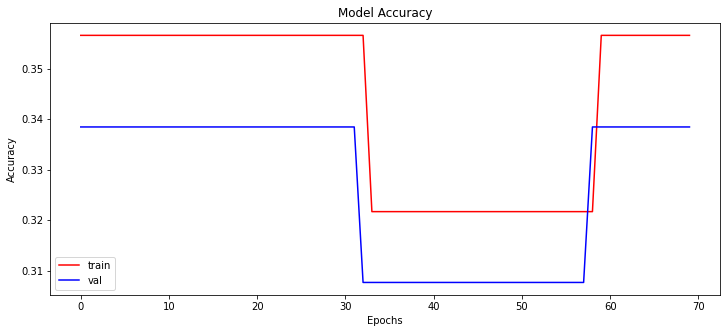

In [25]:
# plot the history
plt.figure(figsize=(12,5))
plt.plot(history.history['accuracy'],color='r')
plt.plot(history.history['val_accuracy'],color='b')
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.legend(['train','val'])

plt.show()

In [26]:
# accuracy calc
Y_pred = model.predict(X_test)
score = model.evaluate(X_test,Y_test)
print('Accuracy over the test set:\n',round((score[1]*100),2),'%')

2/2 [==============================] - 1s 144ms/step - loss: 2.8251 - accuracy: 0.3333
Accuracy over the test set:
 33.33 %


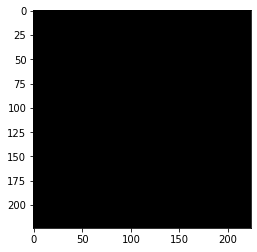

Originally :  scottish_deerhound
Predicted :  scottish_deerhound


In [27]:
# Plottig img to compare
plt.imshow(X_test[1,:,:,:])
plt.show()

#finding max value from prediction list and comparing org value vs predicted
print("Originally : ",labels['breed'][np.argmax(Y_test[1])])
print("Predicted : ",labels['breed'][np.argmax(Y_pred[1])])